# Seattle Housing Prices - Predictive Modeling

### Workflow:

1. Feature Engineering
    - (a) Create dummy variables
    - (b) Adjusting year_renovated column as categorical (yes or no) rather than by date
    - (c) Drop sqft_lot and sqft_lot15
    
    
2. Create Train_Test_Split


3. Run baseline model
    - print RMSE


4. Iterate on model:
    - (a) Remove outliers
    - (b) Remove collinear variables
    - (c) Log transformations
    - (d) Drop non-sig p-values
    - (e) Unit Vectorization (update x-columns to add in unit vectors composed of collinear variables)
    
 

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from itertools import combinations

%run -i "functions/report.py"
%run -i "functions/interactions.py"
%run -i "functions/plot_interactions.py"
%run -i "functions/add_interactions.py"
%run -i "functions/get_polynomials.py"
%run -i "functions/stepwise.py"

#### Import and drop columns:

In [2]:
model_data = pd.read_csv('model_data.csv')
model_data.head()

,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
0,221900.0,3,1180,1.0,0.0,0.0,3,7,0,1955,...,0,1,0,0,0,0,0,0,0,0
1,538000.0,3,2570,2.0,0.0,0.0,3,7,1,1951,...,0,1,0,0,0,0,1,0,0,0
2,180000.0,2,770,1.0,0.0,0.0,3,6,0,1933,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,4,1960,1.0,0.0,0.0,5,7,1,1965,...,0,1,0,0,0,0,1,0,0,0
4,510000.0,3,1680,1.0,0.0,0.0,3,8,0,1987,...,1,0,0,0,0,1,0,0,0,0


1. Vanilla model - no scaling or outliers
2. Outliers/Scaled model - remove outliers, go to $790k, then scale
4. Interactions model
5. Polynomial model 
6. P-Filter Model (still need to decide)


### Now Train-Test-Split

... in preparation for our baseline model

In [3]:
# Your code here - Define the target and predictors
outcome = 'price'
feat_cols = list(model_data.columns)
feat_cols.remove(outcome)

In [5]:
X = model_data[feat_cols]
y = model_data['price']

In [6]:
# Initial test-size of 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Check lengths
print(len(X_train), len(y_test))
X_train.head()

15117 6480


,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
4900,1.0,3,1200,1.0,0.0,0.0,4,7,0,1969,...,0,0,0,0,0,0,0,0,0,0
19664,1.0,3,1920,1.0,0.0,0.0,3,8,0,2014,...,0,0,0,0,0,0,1,0,0,0
13949,1.0,3,1590,1.5,0.0,0.0,4,6,0,1926,...,0,0,0,0,0,1,0,0,0,0
15272,1.0,4,2530,3.0,0.0,2.0,3,9,1,2013,...,0,1,0,0,0,0,0,1,0,0
14411,1.0,3,2010,2.0,0.0,0.0,3,8,1,2014,...,0,0,0,0,0,0,1,0,0,0


### Vanilla Model

#### Side Note: Model Function

In [52]:
# I don't need those predictors/formulas
def training_model(y_train, X_train):
    training_model.model = sm.OLS(y_train, X_train).fit()
    return training_model.model.summary()
    
def rmse_report(X_train, X_test, y_train, model):
    y_hat_train = model.predict(X_train)
    rmse_train = mse(y_train, y_hat_train)**0.5
    y_hat_test = model.predict(X_test)
    rmse_test = mse(y_test, y_hat_test)**0.5
    rmse_vanilla = 177703.18334308316
    print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')
    print('Percent change: ', round(((rmse_test-rmse_train)/rmse_train)*100, 3))
    print('Percent change (Base Model vs. Updated Model): ', round(((rmse_train-rmse_vanilla)/rmse_vanilla)*100, 3))


In [38]:
training_model(y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1135.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:45:06   Log-Likelihood:            -2.0418e+05
No. Observations:               15117   AIC:                         4.085e+05
Df Residuals:                   15074   BIC:                         4.088e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -7.152e+07   4.33e+06    -16.520      0.000      -8e+07    -6.3e+07
bedrooms            -2.55e+04   1982.617    -12.861      0.000   -2.94e+04   -2.16e+04
sqft_living          155.1339      3.539     43.833      0.000     148.197     162.071
floors               3.38e+04   3900.434      8.667      0.000    2.62e+04    4.14e+04
waterfront          6.416e+05   1.89e+04     33.932      0.000    6.05e+05    6.79e+05
view                 4.55e+04   2240.100     20.311      0.000    4.11e+04    4.99e+04
condition            2.56e+04   2517.067     10.170      0.000    2.07e+04    3.05e+04
grade               8.802e+04   2324.057     37.872      0.000    8.35e+04    9.26e+04
basement           -6431.1203   3675.173     -1.750      0.080   -1.36e+04     772.665
yr_built           -1749.0986     79.926    -21.884      0.000   -1905.764   -1592.434
renovated           3.593e+04   8413.864      4.270      0.000    1.94e+04    5.24e+04
lat                 5.838e+05   2.27e+04     25.735      0.000    5.39e+05    6.28e+05
long               -3.816e+05    3.5e+04    -10.908      0.000    -4.5e+05   -3.13e+05
sqft_living15         29.7710      3.772      7.893      0.000      22.378      37.164
month              -3635.3501    468.398     -7.761      0.000   -4553.467   -2717.233
city_Bellevue       2.114e+05   1.18e+04     17.976      0.000    1.88e+05    2.34e+05
city_Black Diamond  1.354e+05   2.37e+04      5.705      0.000    8.89e+04    1.82e+05
city_Bothell       -1.393e+05   1.95e+04     -7.143      0.000   -1.77e+05   -1.01e+05
city_Carnation      4.925e+04   2.64e+04      1.866      0.062   -2489.345    1.01e+05
city_Duvall         -4.83e+04   2.24e+04     -2.160      0.031   -9.21e+04   -4478.730
city_Enumclaw       1.716e+05    1.8e+04      9.533      0.000    1.36e+05    2.07e+05
city_Fall City      1.333e+05   2.75e+04      4.841      0.000    7.93e+04    1.87e+05
city_Federal Way   -7.547e+04   1.14e+04     -6.625      0.000   -9.78e+04   -5.31e+04
city_Issaquah       9.555e+04   1.39e+04      6.850      0.000    6.82e+04    1.23e+05
city_Kenmore       -1.617e+05   1.76e+04     -9.161      0.000   -1.96e+05   -1.27e+05
city_Kent          -5869.1212   9784.253     -0.600      0.549    -2.5e+04    1.33e+04
city_Kirkland       3.719e+04   1.35e+04      2.764      0.006    1.08e+04    6.36e+04
city_Maple Valley   8.188e+04   1.33e+04      6.157      0.000    5.58e+04    1.08e+05
city_Medina         8.837e+05    3.2e+04     27.599      0.000    8.21e+05    9.47e+05
city_Mercer Island  3.108e+05    1.6e+04     19.379      0.000    2.79e+05    3.42e+05
city_North Bend     1.825e+05   2.36e+04      7.748      0.000    1.36e+05    2.29e+05
city_Redmond        4.326e+04   1.43e+04      3.034      0.002    1.53e+04    7.12e+04
city_Renton         -1.35e+04   9969.0

In [39]:
rmse_report(X_train, X_test, y_train, training_model.model)

Train RMSE: 177703.18334308316 
 Test RMSE: 188904.6781261696
Percent change:  6.303


In [252]:
# We see a very high R-squared and large standard errors, likely because of collinearity
# During our EDA, we noted there were several collinear variable pairs to be addressed

With our QQ plot for the vanilla model above, we can see that the graph is not normal with heavy skew on both low and high ends. The upper end has a greater skew showing there are likely a large number of outliers on this end.

We may want to consider reducing outliers at 2 standard deviations (95%) to have the most accurate predictions. The only reason we wouldn't is if we wanted to focus on selling either cheap or luxury homes. If we were doing so, we would have to narrow our data set to these alone.

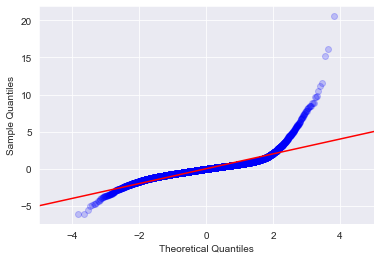

In [40]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### Model 2: Removing Outliers

Going to remove outliers based on 2 standard deviations (95%). This is because our business focus is not on the most expensive or the cheapest homes. So in order to improve our model's prediction for relevant prices, we'll narrow our scope.

#### Comparison of y_train set before and after filtering for 2 standard deviations for price from the full dataset:

In [43]:
# filter the data frame to remove the values exceeding 2 standard deviations based on y (our price)
# Practicing on dataset. Will then apply to our y_train/y_test data 
pmodel_data = model_data[np.abs(stats.zscore(model_data.price)) < 2]

# How many rows were removed & how many rows are left
print(len(model_data.index.difference(pmodel_data.index)))
len(pmodel_data)

841


20756

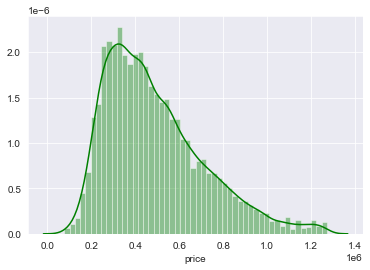

In [44]:
sns.distplot(pmodel_data.price, color='green');

### Further price narrowing to reduce skew and for business case

In [45]:
pmodel_data = pmodel_data[pmodel_data['price'] <= 790000]

In [46]:
X = pmodel_data[feat_cols]
y = pmodel_data['price']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 117)

In [48]:
# Add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [54]:
training_model(y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     758.9
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:52:02   Log-Likelihood:            -1.6555e+05
No. Observations:               12958   AIC:                         3.312e+05
Df Residuals:                   12915   BIC:                         3.315e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4.288e+07    2.3e+06    -18.647      0.000   -4.74e+07   -3.84e+07
bedrooms           -9339.6496   1145.935     -8.150      0.000   -1.16e+04   -7093.448
sqft_living           68.1346      2.228     30.588      0.000      63.768      72.501
floors              2.919e+04   2085.258     13.999      0.000    2.51e+04    3.33e+04
waterfront          8.725e+04   1.83e+04      4.771      0.000    5.14e+04    1.23e+05
view                 2.17e+04   1470.276     14.758      0.000    1.88e+04    2.46e+04
condition           2.085e+04   1300.961     16.027      0.000    1.83e+04    2.34e+04
grade               4.955e+04   1299.898     38.119      0.000     4.7e+04    5.21e+04
basement            7616.0048   1942.840      3.920      0.000    3807.752    1.14e+04
yr_built           -1094.5707     43.545    -25.136      0.000   -1179.926   -1009.215
renovated           1.194e+04   4877.249      2.448      0.014    2380.288    2.15e+04
lat                 4.473e+05   1.14e+04     39.217      0.000    4.25e+05     4.7e+05
long               -1.924e+05   1.86e+04    -10.360      0.000   -2.29e+05   -1.56e+05
sqft_living15         40.6732      2.237     18.184      0.000      36.289      45.058
month              -1872.4038    240.590     -7.783      0.000   -2343.997   -1400.811
city_Bellevue       1.302e+05   6249.390     20.831      0.000    1.18e+05    1.42e+05
city_Black Diamond  1.406e+05   1.18e+04     11.887      0.000    1.17e+05    1.64e+05
city_Bothell       -5.802e+04   9803.067     -5.919      0.000   -7.72e+04   -3.88e+04
city_Carnation       4.15e+04   1.28e+04      3.250      0.001    1.65e+04    6.65e+04
city_Duvall        -3.268e+04    1.1e+04     -2.973      0.003   -5.42e+04   -1.11e+04
city_Enumclaw       1.099e+05   8661.153     12.694      0.000     9.3e+04    1.27e+05
city_Fall City      9.825e+04   1.49e+04      6.605      0.000    6.91e+04    1.27e+05
city_Federal Way   -4.663e+04   5483.589     -8.503      0.000   -5.74e+04   -3.59e+04
city_Issaquah       1.269e+05   7055.397     17.990      0.000    1.13e+05    1.41e+05
city_Kenmore       -7.714e+04   8631.606     -8.937      0.000   -9.41e+04   -6.02e+04
city_Kent           -1.36e+04   4658.074     -2.920      0.004   -2.27e+04   -4470.251
city_Kirkland       3.351e+04   6841.546      4.898      0.000    2.01e+04    4.69e+04
city_Maple Valley   5.488e+04   6516.619      8.422      0.000    4.21e+04    6.77e+04
city_Medina         3.963e+05   8.59e+04      4.614      0.000    2.28e+05    5.65e+05
city_Mercer Island  2.209e+05   1.31e+04     16.851      0.000    1.95e+05    2.47e+05
city_North Bend     1.274e+05   1.18e+04     10.816      0.000    1.04e+05    1.51e+05
city_Redmond        9.933e+04   7174.750     13.845      0.000    8.53e+04    1.13e+05
city_Renton         4630.5702   4812.8

In [55]:
rmse_report(X_train, X_test, y_train, training_model.model)

Train RMSE: 85556.9037960636 
 Test RMSE: 87245.36622062251
Percent change:  1.973
Percent change (Base Model vs. Updated Model):  -51.854


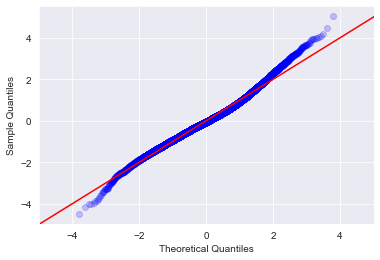

In [50]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### Model 3: Scaling

Scaling after train, test, split to prevent data leakage

In [104]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

# returning column names, adding constant
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)


# resetting index
X_train_norm.set_index(y_train.index, inplace=True)
X_test_norm.set_index(y_test.index, inplace=True)

In [103]:
X_train_norm

,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,bath_1,bath_2,bath_3,bath_4,bath_5
6027,0.0,0.333333,0.246114,0.0,0.0,0.0,0.50,0.500,1.0,0.478261,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19378,0.0,0.333333,0.268320,0.0,0.0,0.0,0.50,0.500,1.0,0.539130,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9289,0.0,0.222222,0.307180,0.0,0.0,0.0,0.50,0.750,0.0,0.860870,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6209,0.0,0.333333,0.303479,0.0,0.0,0.0,0.75,0.500,1.0,0.495652,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4256,0.0,0.222222,0.223908,0.0,0.0,0.0,0.75,0.500,1.0,0.078261,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,0.0,0.444444,0.507032,0.4,0.0,0.0,0.50,0.625,0.0,0.930435,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18532,0.0,0.111111,0.186899,0.0,0.0,0.0,0.75,0.625,1.0,0.269565,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7244,0.0,0.222222,0.201702,0.0,0.0,0.0,0.75,0.500,1.0,0.695652,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10798,0.0,0.222222,0.122132,0.0,0.0,0.0,0.75,0.500,0.0,0.521739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
X_train_norm.drop('const', axis=1, inplace=True)
X_test_norm.drop('const', axis=1, inplace=True)
X_train_norm = sm.add_constant(X_train_norm)
X_test_norm = sm.add_constant(X_test_norm)

In [106]:
training_model(y_train, X_train_norm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     758.9
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:09:00   Log-Likelihood:            -1.6555e+05
No. Observations:               12958   AIC:                         3.312e+05
Df Residuals:                   12915   BIC:                         3.315e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.659e+04   9323.540     -7.142      0.000   -8.49e+04   -4.83e+04
bedrooms           -8.406e+04   1.03e+04     -8.150      0.000   -1.04e+05   -6.38e+04
sqft_living         3.682e+05    1.2e+04     30.588      0.000    3.45e+05    3.92e+05
floors              7.298e+04   5213.144     13.999      0.000    6.28e+04    8.32e+04
waterfront          8.725e+04   1.83e+04      4.771      0.000    5.14e+04    1.23e+05
view                 8.68e+04   5881.105     14.758      0.000    7.53e+04    9.83e+04
condition            8.34e+04   5203.844     16.027      0.000    7.32e+04    9.36e+04
grade               3.964e+05   1.04e+04     38.119      0.000    3.76e+05    4.17e+05
basement            7616.0048   1942.840      3.920      0.000    3807.752    1.14e+04
yr_built           -1.259e+05   5007.727    -25.136      0.000   -1.36e+05   -1.16e+05
renovated           1.194e+04   4877.249      2.448      0.014    2380.288    2.15e+04
lat                 2.766e+05   7051.894     39.217      0.000    2.63e+05     2.9e+05
long               -2.316e+05   2.24e+04    -10.360      0.000   -2.75e+05   -1.88e+05
sqft_living15       1.737e+05   9553.301     18.184      0.000    1.55e+05    1.92e+05
month               -2.06e+04   2646.494     -7.783      0.000   -2.58e+04   -1.54e+04
city_Bellevue       1.302e+05   6249.390     20.831      0.000    1.18e+05    1.42e+05
city_Black Diamond  1.406e+05   1.18e+04     11.887      0.000    1.17e+05    1.64e+05
city_Bothell       -5.802e+04   9803.067     -5.919      0.000   -7.72e+04   -3.88e+04
city_Carnation       4.15e+04   1.28e+04      3.250      0.001    1.65e+04    6.65e+04
city_Duvall        -3.268e+04    1.1e+04     -2.973      0.003   -5.42e+04   -1.11e+04
city_Enumclaw       1.099e+05   8661.153     12.694      0.000     9.3e+04    1.27e+05
city_Fall City      9.825e+04   1.49e+04      6.605      0.000    6.91e+04    1.27e+05
city_Federal Way   -4.663e+04   5483.589     -8.503      0.000   -5.74e+04   -3.59e+04
city_Issaquah       1.269e+05   7055.397     17.990      0.000    1.13e+05    1.41e+05
city_Kenmore       -7.714e+04   8631.606     -8.937      0.000   -9.41e+04   -6.02e+04
city_Kent           -1.36e+04   4658.074     -2.920      0.004   -2.27e+04   -4470.251
city_Kirkland       3.351e+04   6841.546      4.898      0.000    2.01e+04    4.69e+04
city_Maple Valley   5.488e+04   6516.619      8.422      0.000    4.21e+04    6.77e+04
city_Medina         3.963e+05   8.59e+04      4.614      0.000    2.28e+05    5.65e+05
city_Mercer Island  2.209e+05   1.31e+04     16.851      0.000    1.95e+05    2.47e+05
city_North Bend     1.274e+05   1.18e+04     10.816      0.000    1.04e+05    1.51e+05
city_Redmond        9.933e+04   7174.750     13.845      0.000    8.53e+04    1.13e+05
city_Renton         4630.5702   4812.8

In [107]:
rmse_report(X_train_norm, X_test_norm, y_train, training_model.model)

Train RMSE: 85556.9037960637 
 Test RMSE: 87245.36622062171
Percent change:  1.973
Percent change (Base Model vs. Updated Model):  -51.854


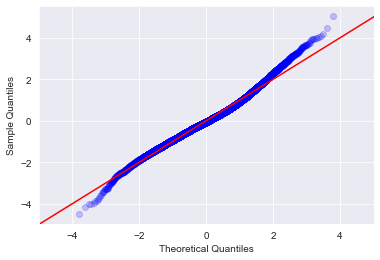

In [108]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### Model: Interactions

In [84]:
linreg = LinearRegression()
model_int = linreg.fit(X_train_norm, y_train)

Testing 903 combinations.

R^2 including interaction of long and city_Seattle: 0.719


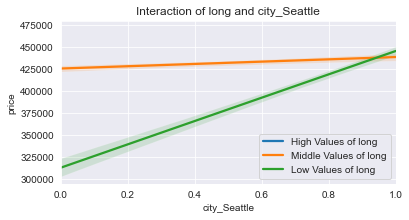

*********************

R^2 including interaction of lat and city_Kirkland: 0.717


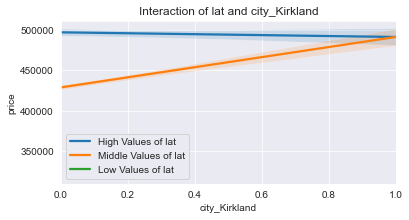

*********************

R^2 including interaction of yr_built and long: 0.716


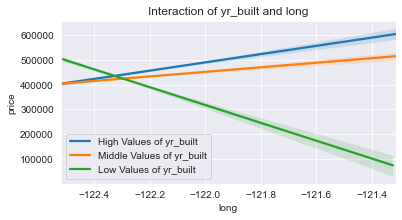

*********************

R^2 including interaction of yr_built and city_Seattle: 0.716


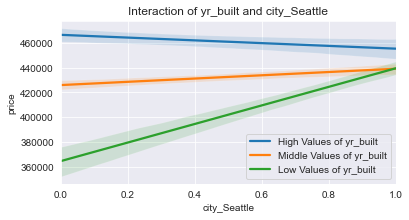

*********************

R^2 including interaction of grade and city_Seattle: 0.715


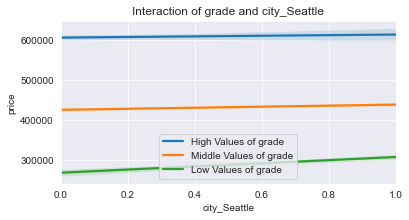

*********************

R^2 including interaction of sqft_living15 and city_Federal Way: 0.714


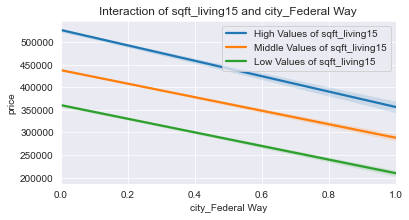

*********************

R^2 including interaction of sqft_living and lat: 0.714


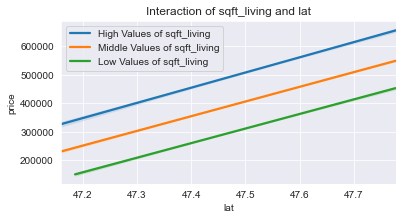

*********************

R^2 including interaction of sqft_living and basement: 0.714


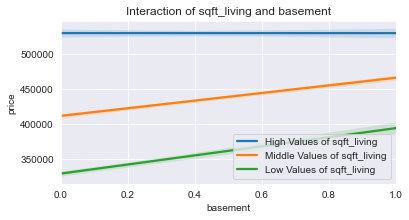

*********************

R^2 including interaction of long and city_Kent: 0.714


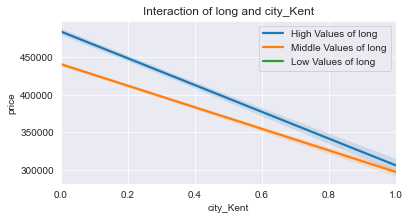

*********************

R^2 including interaction of grade and city_Federal Way: 0.714


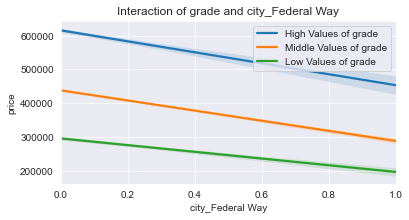

*********************

R^2 including interaction of basement and city_Seattle: 0.714


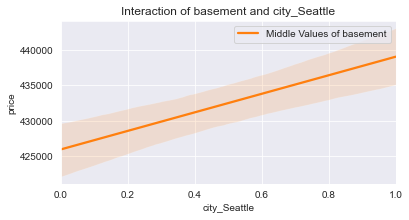

*********************

R^2 including interaction of sqft_living and yr_built: 0.713


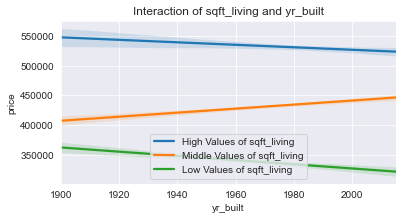

*********************

R^2 including interaction of sqft_living and view: 0.713


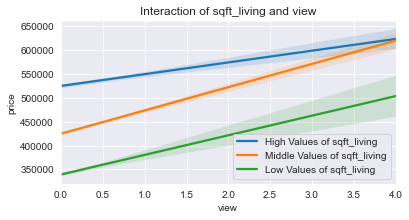

*********************

R^2 including interaction of sqft_living and sqft_living15: 0.713


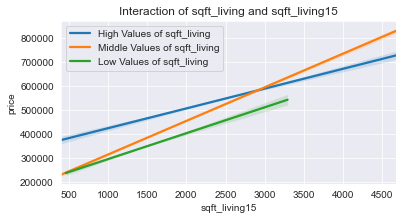

*********************

R^2 including interaction of sqft_living and floors: 0.713


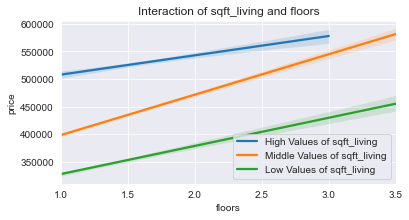

*********************



In [110]:
interactions = find_interactions(15, model_int, X_train_norm)

In [111]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('yr_built', 'long'),
 ('yr_built', 'city_Seattle'),
 ('grade', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'basement'),
 ('long', 'city_Kent'),
 ('grade', 'city_Federal Way'),
 ('basement', 'city_Seattle'),
 ('sqft_living', 'yr_built'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15'),
 ('sqft_living', 'floors')]

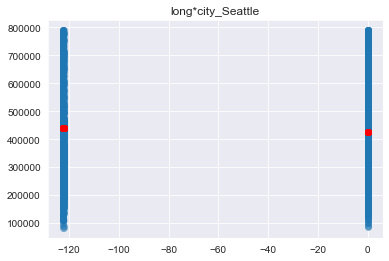

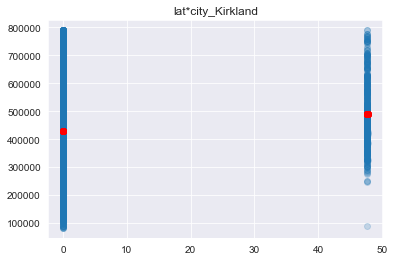

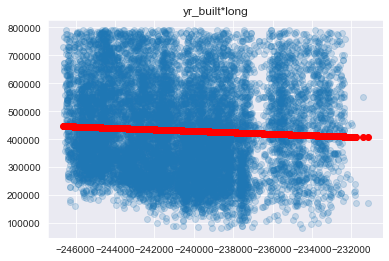

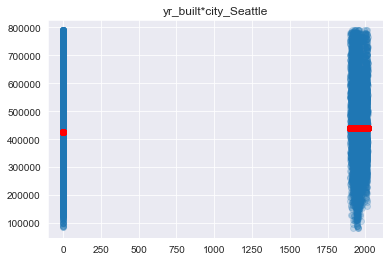

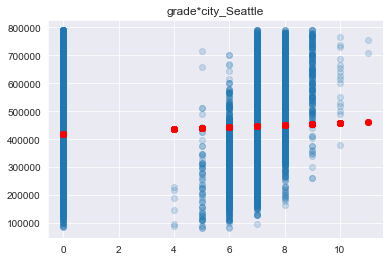

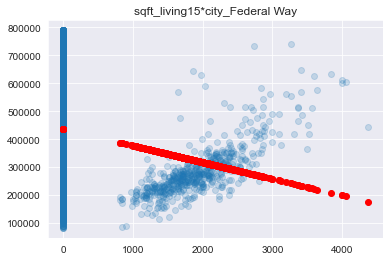

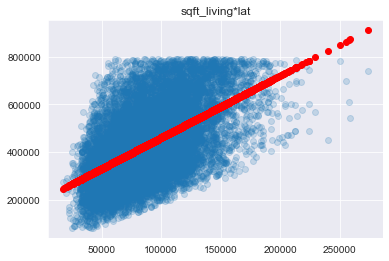

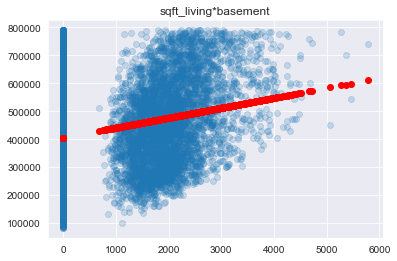

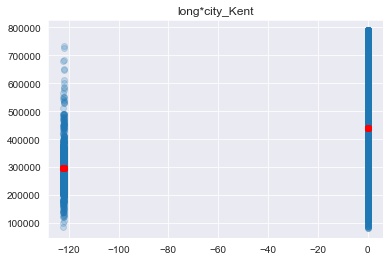

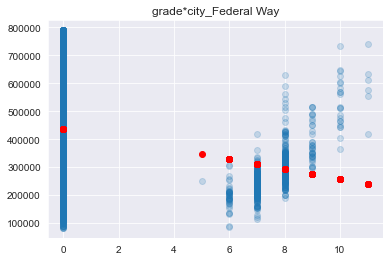

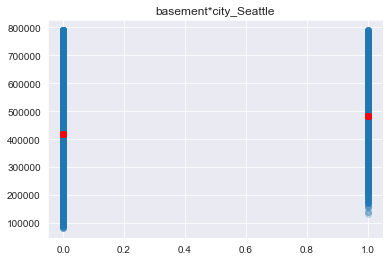

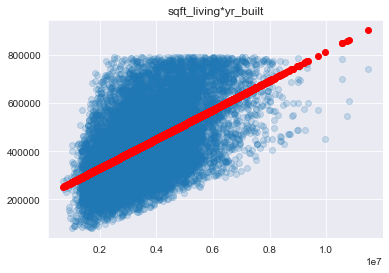

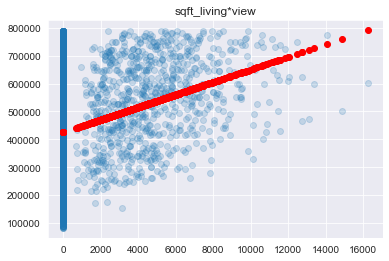

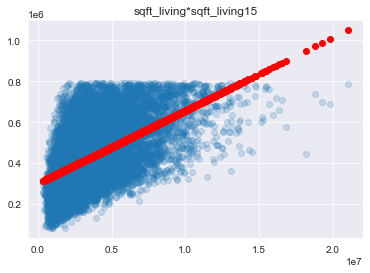

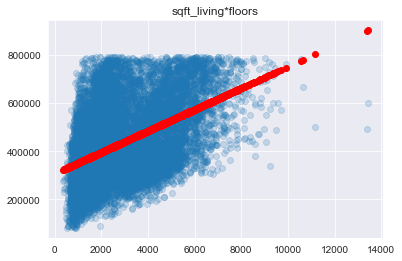

In [112]:
for inter in interactions:
    var = pd.DataFrame(X_train[inter[0]] * X_train[inter[1]])
    linreg = LinearRegression()
    model = linreg.fit(var, y_train)
    y_pred = model.predict(var)
    plt.scatter(var, y_train, alpha=.2)
    plt.scatter(var, y_pred, c='red')
    plt.title('{}*{}'.format(inter[0], inter[1]))
    plt.show()

In [113]:
remove = [('yr_built', 'long'),
          ('yr_built', 'city_Seattle')]
for inter in remove:
    interactions.remove(inter)

In [114]:
interactions

[('long', 'city_Seattle'),
 ('lat', 'city_Kirkland'),
 ('grade', 'city_Seattle'),
 ('sqft_living15', 'city_Federal Way'),
 ('sqft_living', 'lat'),
 ('sqft_living', 'basement'),
 ('long', 'city_Kent'),
 ('grade', 'city_Federal Way'),
 ('basement', 'city_Seattle'),
 ('sqft_living', 'yr_built'),
 ('sqft_living', 'view'),
 ('sqft_living', 'sqft_living15'),
 ('sqft_living', 'floors')]

In [115]:
model_int, X_train2, X_test2 = add_interactions(interactions, 
                                             X_train_norm, X_test_norm)

Interaction Added: long * city_Seattle
Current R^2: 0.71881
Current Test MSE: 7365840046.55173
Current MSE Difference: -7365840045.83292

Interaction Added: grade * city_Seattle
Current R^2: 0.72165
Current Test MSE: 7307206317.02898
Current MSE Difference: -7307206316.30733

Interaction Added: sqft_living * basement
Current R^2: 0.72417
Current Test MSE: 7240214113.87507
Current MSE Difference: -7240214113.1509

Interaction Added: lat * city_Kirkland
Current R^2: 0.72675
Current Test MSE: 7103632243.53544
Current MSE Difference: -7103632242.80869

Interaction Added: sqft_living * lat
Current R^2: 0.73082
Current Test MSE: 7067047814.80794
Current MSE Difference: -7067047814.07712

Interaction Added: sqft_living * yr_built
Current R^2: 0.73241
Current Test MSE: 7012298906.30431
Current MSE Difference: -7012298905.5719

Interaction Added: sqft_living * sqft_living15
Current R^2: 0.73334
Current Test MSE: 6982152972.78197
Current MSE Difference: -6982152972.04863

Interaction Added: base

In [116]:
X_train2 = sm.add_constant(X_train2)
X_test2 = sm.add_constant(X_test2)

training_model(y_train, X_train2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     663.8
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:11:51   Log-Likelihood:            -1.6500e+05
No. Observations:               12958   AIC:                         3.301e+05
Df Residuals:                   12903   BIC:                         3.305e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -3.666e+04   1.36e+04     -2.689      0.007   -6.34e+04   -9934.020
bedrooms                    -8.711e+04      1e+04     -8.673      0.000   -1.07e+05   -6.74e+04
sqft_living                  2.037e+05   3.32e+04      6.139      0.000    1.39e+05    2.69e+05
floors                       4.146e+04   1.16e+04      3.562      0.000    1.86e+04    6.43e+04
waterfront                   7.699e+04   1.78e+04      4.324      0.000    4.21e+04    1.12e+05
view                         1.403e+05   1.43e+04      9.783      0.000    1.12e+05    1.68e+05
condition                    7.614e+04   5038.422     15.112      0.000    6.63e+04     8.6e+04
grade                        3.343e+05    1.2e+04     27.896      0.000    3.11e+05    3.58e+05
basement                     2.222e+04   5169.052      4.300      0.000    1.21e+04    3.24e+04
yr_built                    -2.083e+05   1.02e+04    -20.456      0.000   -2.28e+05   -1.88e+05
renovated                    8562.9085   4702.406      1.821      0.069    -654.502    1.78e+04
lat                          2.226e+05   9686.124     22.983      0.000    2.04e+05    2.42e+05
long                        -1360.9526   3.14e+04     -0.043      0.965   -6.28e+04    6.01e+04
sqft_living15                2.474e+05   1.72e+04     14.406      0.000    2.14e+05    2.81e+05
month                       -1.968e+04   2538.467     -7.754      0.000   -2.47e+04   -1.47e+04
city_Bellevue                1.232e+05   6191.350     19.893      0.000    1.11e+05    1.35e+05
city_Black Diamond            9.76e+04   1.21e+04      8.084      0.000    7.39e+04    1.21e+05
city_Bothell                -6.291e+04   9575.992     -6.569      0.000   -8.17e+04   -4.41e+04
city_Carnation              -3.115e+04   1.39e+04     -2.247      0.025   -5.83e+04   -3980.907
city_Duvall                 -8.945e+04   1.17e+04     -7.664      0.000   -1.12e+05   -6.66e+04
city_Enumclaw                6.473e+04   9355.086      6.919      0.000    4.64e+04    8.31e+04
city_Fall City               3.481e+04   1.54e+04      2.256      0.024    4563.546    6.51e+04
city_Federal Way             7.678e+04    1.9e+04      4.049      0.000    3.96e+04    1.14e+05
city_Issaquah                9.801e+04   7685.511     12.753      0.000    8.29e+04    1.13e+05
city_Kenmore                -7.185e+04   8434.233     -8.519      0.000   -8.84e+04   -5.53e+04
city_Kent                   -1.109e+05   1.92e+04     -5.779      0.000   -1.49e+05   -7.33e+04
city_Kirkland                1.479e+06   9.18e+04     16.115      0.000     1.3e+06    1.66e+06
city_Maple Valley            2.019e+04   7150.416      2.823      0.005    6170.936    3.42e+04
city_Medina                  3.988e+05   8.23e+04      4.843      0.000    2.37e+05     5.6e+05
city_Mercer

In [119]:
rmse_report(X_train2, X_test2, y_train, training_model.model)

Train RMSE: 81971.53284270049 
 Test RMSE: 83208.66279302954
Percent change:  1.509
Percent change (Base Model vs. Updated Model):  -53.872


In [117]:
model_int = sm.OLS(y_train, X_train2).fit()

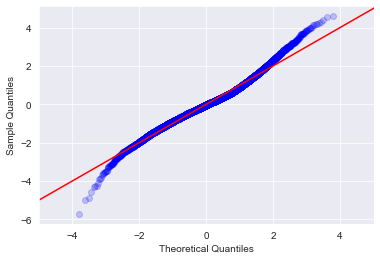

In [118]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(model_int.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

In [393]:
# Adding interactions decreased RMSE and improved R-squared

### Model: Polynomial Features

Factor bedrooms by 2. R^2: 23837080334.60796


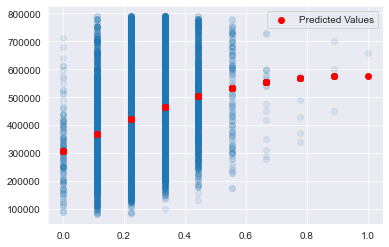

Factor sqft_living by 2. R^2: 18308245908.36213


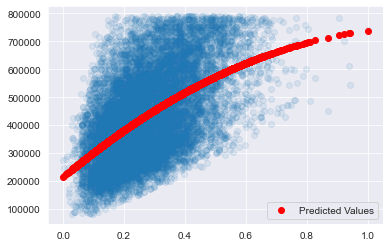

Factor floors by 2. R^2: 23617580764.78374


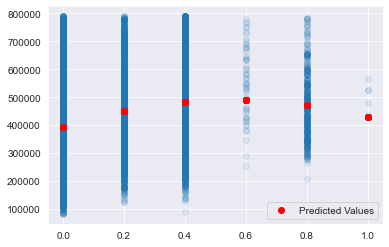

Factor view by 2. R^2: 24607279572.66134


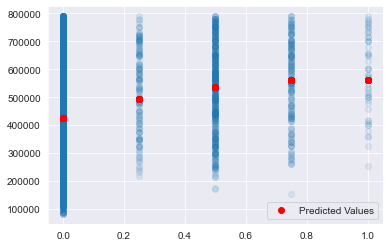

Factor condition by 2. R^2: 25361510683.37368


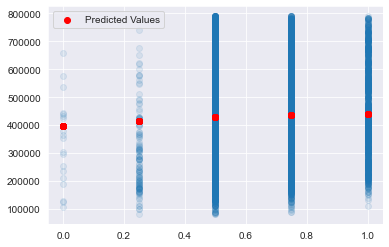

Factor grade by 2. R^2: 17820344420.42374


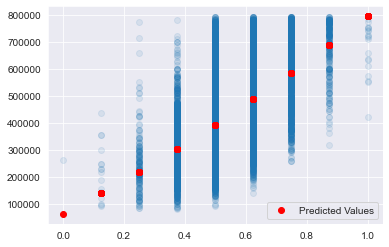

Factor yr_built by 2. R^2: 24394482490.64416


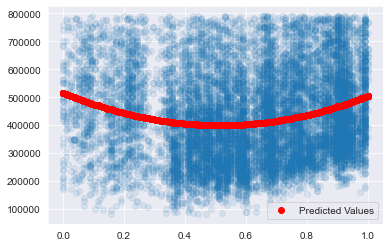

Factor lat by 2. R^2: 19333589905.36048


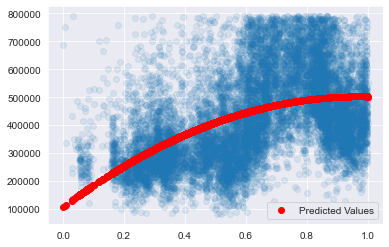

Factor long by 2. R^2: 25204603441.98104


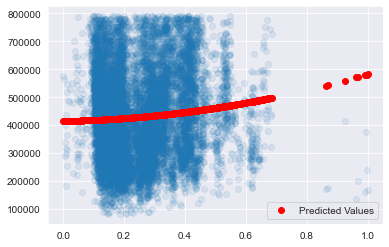

Factor sqft_living15 by 2. R^2: 19549262203.05532


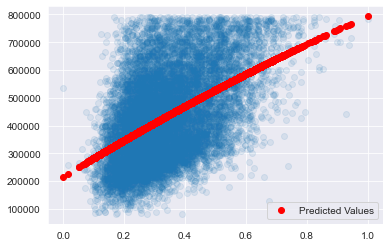

Factor month by 2. R^2: 25360068924.68963


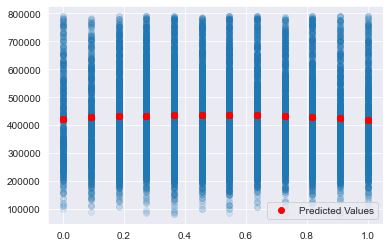

Factor city_Bellevue by 2. R^2: 24527726142.84702


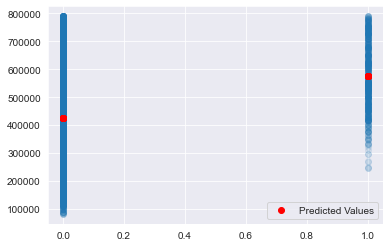

Factor long * city_Seattle by 2. R^2: 24991302414.24697


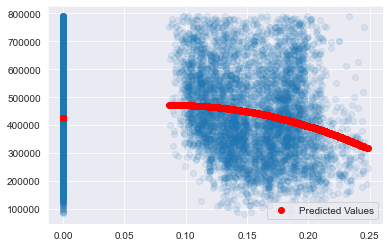

Factor grade * city_Seattle by 2. R^2: 23108103734.19218


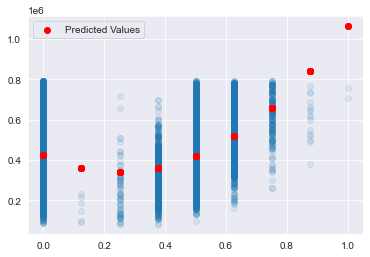

Factor sqft_living * basement by 2. R^2: 23627437186.28588


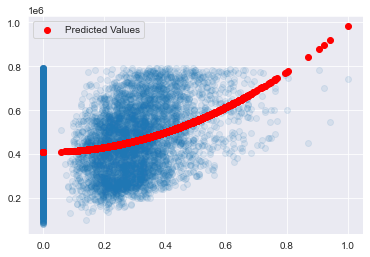

Factor lat * city_Kirkland by 2. R^2: 25050183132.18149


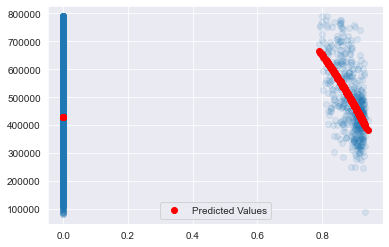

Factor sqft_living * lat by 2. R^2: 11808352939.15662


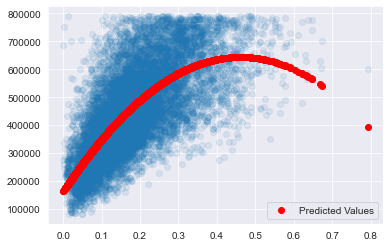

Factor sqft_living * yr_built by 2. R^2: 21631056582.5673


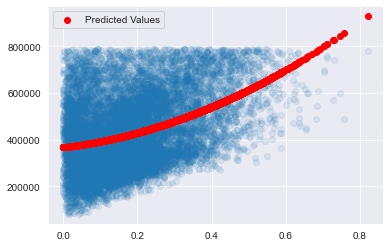

Factor sqft_living * sqft_living15 by 2. R^2: 18031787756.84694


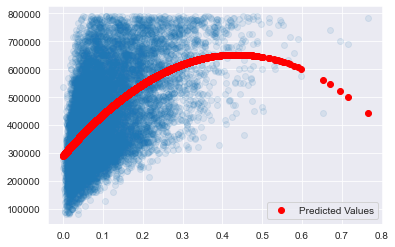

Factor grade * city_Federal Way by 2. R^2: 24235051238.96339


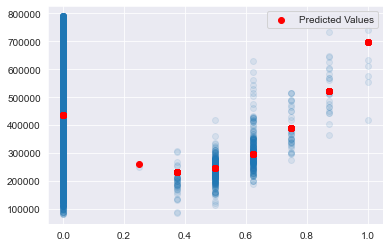

Factor long * city_Kent by 2. R^2: 24140845772.72771


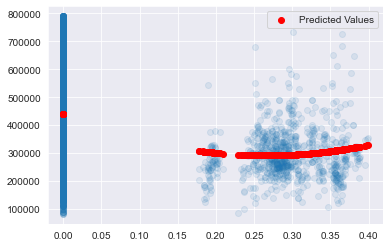

Factor sqft_living * view by 2. R^2: 24440330986.4258


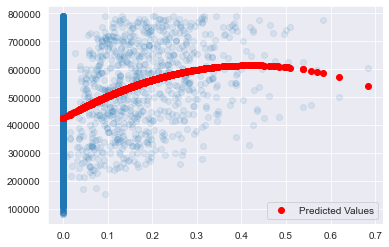

Factor sqft_living * floors by 2. R^2: 21914196045.53745


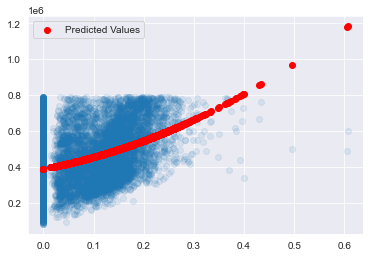

In [120]:
poly_feat = get_polynomial_features(X_train2, 
                                    max_degree = 2)

In [169]:
poly_feat

[('bedrooms', 2),
 ('sqft_living', 2),
 ('floors', 2),
 ('view', 2),
 ('condition', 2),
 ('grade', 2),
 ('yr_built', 2),
 ('lat', 2),
 ('long', 2),
 ('sqft_living15', 2),
 ('month', 2),
 ('city_Bellevue', 2),
 ('long * city_Seattle', 2),
 ('yr_built * city_Seattle', 2),
 ('grade * city_Seattle', 2),
 ('sqft_living * basement', 2),
 ('lat * city_Kirkland', 2),
 ('sqft_living * lat', 2),
 ('sqft_living * yr_built', 2),
 ('sqft_living * view', 2),
 ('grade * city_Federal Way', 2),
 ('long * city_Kent', 2),
 ('sqft_living * sqft_living15', 2),
 ('sqft_living15 * city_Federal Way', 2),
 ('yr_built * long', 2)]

In [121]:
#Perform the same function as PolynomialFeatures, but name
# the columns.
X_train3 = X_train2.loc[:]
X_test3 = X_test2.loc[:]
for feat in poly_feat:
    factor = 2
    while factor <= feat[1]:
        poly_train = X_train2[feat[0]]**factor
        poly_test = X_test2[feat[0]]**factor
        poly_X = X[feat[0]]**factor
        X_train3['{}^{}'.format(feat[0], factor)]=poly_train
        X_test3['{}^{}'.format(feat[0], factor)]=poly_test
        X['{}^{}'.format(feat[0], factor)]=poly_X
        factor +=1

In [122]:
X_train3 = sm.add_constant(X_train3)
X_test3 = sm.add_constant(X_test3)

In [123]:
model_poly = sm.OLS(y_train, X_train3).fit()

In [125]:
training_model(y_train, X_train3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     532.7
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:14:24   Log-Likelihood:            -1.6440e+05
No. Observations:               12958   AIC:                         3.289e+05
Df Residuals:                   12881   BIC:                         3.295e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -2.092e+05   2.74e+04     -7.642      0.000   -2.63e+05   -1.56e+05
bedrooms                      -5.724e+04   2.84e+04     -2.018      0.044   -1.13e+05   -1641.943
sqft_living                    1.692e+05    8.3e+04      2.038      0.042    6427.307    3.32e+05
floors                         -1.25e+05   2.33e+04     -5.358      0.000   -1.71e+05   -7.93e+04
waterfront                     9.225e+04   1.86e+04      4.955      0.000    5.58e+04    1.29e+05
view                           3.533e+04   3.62e+04      0.975      0.330   -3.57e+04    1.06e+05
condition                      1.023e+05   2.97e+04      3.446      0.001    4.41e+04    1.61e+05
grade                          1.096e+05   5.49e+04      1.997      0.046    1997.378    2.17e+05
basement                       4725.5914   9076.123      0.521      0.603   -1.31e+04    2.25e+04
yr_built                        -2.8e+05   2.22e+04    -12.606      0.000   -3.24e+05   -2.37e+05
renovated                      1.091e+04   4501.776      2.423      0.015    2085.797    1.97e+04
lat                            1.172e+06    4.9e+04     23.944      0.000    1.08e+06    1.27e+06
long                            2.33e+05   7.27e+04      3.205      0.001    9.05e+04    3.76e+05
sqft_living15                  2.798e+05   4.09e+04      6.845      0.000       2e+05     3.6e+05
month                         -1.952e+04   9214.259     -2.119      0.034   -3.76e+04   -1461.440
city_Bellevue                 -1.928e+04   4473.864     -4.309      0.000    -2.8e+04   -1.05e+04
city_Black Diamond             5.342e+04   1.19e+04      4.494      0.000    3.01e+04    7.67e+04
city_Bothell                   -1.71e+05   1.01e+04    -16.896      0.000   -1.91e+05   -1.51e+05
city_Carnation                 -1.85e+05   1.46e+04    -12.647      0.000   -2.14e+05   -1.56e+05
city_Duvall                   -2.237e+05   1.24e+04    -18.062      0.000   -2.48e+05   -1.99e+05
city_Enumclaw                  1.799e+05   1.05e+04     17.079      0.000    1.59e+05    2.01e+05
city_Fall City                -1.351e+05   1.63e+04     -8.298      0.000   -1.67e+05   -1.03e+05
city_Federal Way               1.539e+05   5.98e+04      2.571      0.010    3.65e+04    2.71e+05
city_Issaquah                 -7.004e+04   9996.942     -7.006      0.000   -8.96e+04   -5.04e+04
city_Kenmore                  -1.795e+05   9118.429    -19.683      0.000   -1.97e+05   -1.62e+05
city_Kent                      1.051e+05   7.33e+04      1.434      0.152   -3.86e+04    2.49e+05
city_Kirkland                  7.383e+05   2.14e+06      0.345      0.730   -3.46e+06    4.93e+06
city_Maple Valley             -5.824e+04   7770.369     -7.495      0.000   -7.35e+04    -4.3e+04
city_Medina                    2.461e+05    7

In [126]:
rmse_report(X_train3, X_test3, y_train, training_model.model)

Train RMSE: 78279.2081482428 
 Test RMSE: 79442.72429064412
Percent change:  1.486
Percent change (Base Model vs. Updated Model):  -55.949


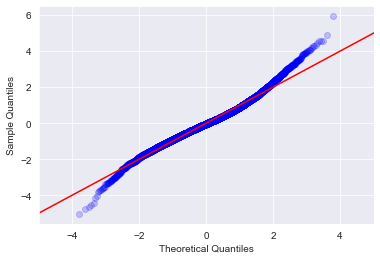

In [131]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### P-Value Filter

In [130]:
results = stepwise_selection(X_train3, y_train)
X_train4 = X_train3.loc[:,results]
X_test4 = X_test3.loc[:,results]
X = X.loc[:,results]

/Users/stephenenke/Documents/DSC-Project-2/Seattle-Housing-Regression-Analysis/functions/stepwise.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  lat                            with p-value 0.0
Add  sqft_living * yr_built^2       with p-value 0.0
Add  sqft_living15^2                with p-value 0.0
Add  sqft_living * lat              with p-value 0.0
Drop sqft_living * yr_built^2       with p-value 0.411507
Add  grade                          with p-value 0.0
Add  yr_built                       with p-value 3.06194e-227
Add  lat^2                          with p-value 3.10072e-154
Add  city_Enumclaw                  with p-value 2.04369e-127
Add  const                          with p-value 6.65598e-154
Add  city_Renton                    with p-value 4.68497e-90
Add  sqft_living * lat^2            with p-value 1.98203e-88
Add  condition                      with p-value 6.17455e-62
Add  yr_built^2                     with p-value 5.34958e-86
Add  view                           with p-value 1.1888e-68
Add  long * city_Seattle^2          with p-value 4.54404e-72
Add  city_Kent                      with p-value 1.16293e-63
Add

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [133]:
training_model(y_train, X_train4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     755.0
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:17:21   Log-Likelihood:            -1.6446e+05
No. Observations:               12958   AIC:                         3.290e+05
Df Residuals:                   12904   BIC:                         3.294e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
lat                          9.049e+05   3.38e+04     26.752      0.000    8.39e+05    9.71e+05
sqft_living * lat            5.914e+05    6.7e+04      8.828      0.000     4.6e+05    7.23e+05
grade                        3.222e+05   1.13e+04     28.405      0.000       3e+05    3.44e+05
yr_built                    -2.904e+05   1.98e+04    -14.700      0.000   -3.29e+05   -2.52e+05
lat^2                       -5.274e+05   2.28e+04    -23.146      0.000   -5.72e+05   -4.83e+05
city_Enumclaw                1.846e+05   8470.449     21.792      0.000    1.68e+05    2.01e+05
const                       -1.684e+05   1.49e+04    -11.327      0.000   -1.98e+05   -1.39e+05
city_Renton                  -8.88e+04   3507.815    -25.316      0.000   -9.57e+04   -8.19e+04
sqft_living * lat^2         -5.528e+05   8.04e+04     -6.879      0.000    -7.1e+05   -3.95e+05
condition                    8.492e+04   4817.106     17.629      0.000    7.55e+04    9.44e+04
yr_built^2                   1.857e+05   1.51e+04     12.296      0.000    1.56e+05    2.15e+05
view                         1.063e+05   7994.654     13.295      0.000    9.06e+04    1.22e+05
long * city_Seattle^2        6.391e+06   9.16e+05      6.977      0.000     4.6e+06    8.19e+06
city_Kent                   -1.281e+05   9486.093    -13.508      0.000   -1.47e+05    -1.1e+05
long^2                      -1.485e+05   1.82e+04     -8.167      0.000   -1.84e+05   -1.13e+05
city_Kenmore                -1.303e+05   6541.251    -19.926      0.000   -1.43e+05   -1.18e+05
city_Duvall                 -1.358e+05   7629.086    -17.798      0.000   -1.51e+05   -1.21e+05
city_Bothell                -1.143e+05   7742.126    -14.763      0.000   -1.29e+05   -9.91e+04
city_Woodinville              -7.6e+04   5800.102    -13.102      0.000   -8.74e+04   -6.46e+04
city_Mercer Island           1.326e+05   1.18e+04     11.254      0.000    1.09e+05    1.56e+05
city_Black Diamond           1.024e+05   1.01e+04     10.167      0.000    8.26e+04    1.22e+05
lat * city_Kirkland^2       -8.388e+05    5.7e+04    -14.712      0.000   -9.51e+05   -7.27e+05
city_Kirkland                6.188e+05    4.5e+04     13.741      0.000    5.31e+05    7.07e+05
sqft_living15                2.576e+05    1.9e+04     13.556      0.000     2.2e+05    2.95e+05
long * city_Kent^2           7.914e+05    9.8e+04      8.073      0.000    5.99e+05    9.84e+05
sqft_living * yr_built^2     4.892e+05   7.74e+04      6.323      0.000    3.38e+05    6.41e+05
city_Carnation              -8.362e+04   9320.740     -8.971      0.000   -1.02e+05   -6.53e+04
month                         -2.1e+04   2435.527     -8.623      0.000   -2.58e+04   -1.62e+04
city_Bellevue                1.651e+04   2249.511      7.339      0.000    1.21e+04    2.09e+04
city_Bellev

In [134]:
rmse_report(X_train4, X_test4, y_train, training_model.model)

Train RMSE: 78677.4570001272 
 Test RMSE: 79433.03255976223
Percent change:  0.96
Percent change (Base Model vs. Updated Model):  -55.725


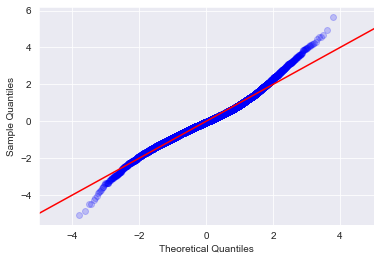

In [135]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
sm.graphics.qqplot(training_model.model.resid, line='45', fit=True, alpha=0.2, ax=ax)
ax.set_xlim(-5, 5);

### Sklearn Feature Selector

In [194]:
len(X_train3.columns)

82

In [ ]:
from sklearn.feature_selection import RFE

In [195]:
#no of features
nof_list=np.arange(1,82)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train3,y_train)
    X_test_rfe = rfe.transform(X_test3)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 0.25 passing these as

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=31 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=33 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=34 as keyword args. From version 0.25 passing thes

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=61 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=62 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=63 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=64 as keyword args. From version 0.25 passing thes

Optimum number of features: 81
Score with 81 features: 0.754611


In [234]:
cols = list(X_train3.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 81)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train3,y_train)  
#Fitting the data to model
model.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['bedrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'basement', 'yr_built', 'renovated', 'lat', 'long',
       'sqft_living15', 'month', 'city_Bellevue', 'city_Black Diamond',
       'city_Bothell', 'city_Carnation', 'city_Duvall', 'city_Enumclaw',
       'city_Fall City', 'city_Federal Way', 'city_Issaquah', 'city_Kenmore',
       'city_Kent', 'city_Kirkland', 'city_Maple Valley', 'city_Medina',
       'city_Mercer Island', 'city_North Bend', 'city_Redmond', 'city_Renton',
       'city_Sammamish', 'city_Seattle', 'city_Snoqualmie', 'city_Vashon',
       'city_Woodinville', 'bath_1', 'bath_2', 'bath_3', 'bath_4', 'bath_5',
       'long * city_Seattle', 'yr_built * city_Seattle',
       'grade * city_Seattle', 'sqft_living * basement', 'lat * city_Kirkland',
       'sqft_living * lat', 'sqft_living * yr_built', 'sqft_living * view',
       'grade * city_Federal Way', 'basement * city_Seattle',
       'long * city_Kent', 'sqft_living * sqft_livi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=81 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [235]:
model.score(X_rfe, y_train)

0.7623407402689477

In [208]:
rfe_cols = list(selected_features_rfe)

In [213]:
X_train3[rfe_cols]

,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,renovated,...,sqft_living * basement^2,lat * city_Kirkland^2,sqft_living * lat^2,sqft_living * yr_built^2,sqft_living * view^2,grade * city_Federal Way^2,long * city_Kent^2,sqft_living * sqft_living15^2,sqft_living15 * city_Federal Way^2,yr_built * long^2
6027,0.333333,0.246114,0.0,0.0,0.0,0.50,0.500,1.0,0.478261,1.0,...,0.060572,0.0,0.027697,0.013855,0.0,0.00,0.000000,0.004950,0.000000,0.021137
19378,0.333333,0.268320,0.0,0.0,0.0,0.50,0.500,1.0,0.539130,0.0,...,0.071995,0.0,0.068114,0.020926,0.0,0.00,0.000000,0.005138,0.000000,0.007238
9289,0.222222,0.307180,0.0,0.0,0.0,0.50,0.750,0.0,0.860870,0.0,...,0.000000,0.0,0.013619,0.069929,0.0,0.00,0.000000,0.011193,0.000000,0.000008
6209,0.333333,0.303479,0.0,0.0,0.0,0.75,0.500,1.0,0.495652,0.0,...,0.092099,0.0,0.083947,0.022626,0.0,0.00,0.000000,0.006120,0.000000,0.004558
4256,0.222222,0.223908,0.0,0.0,0.0,0.75,0.500,1.0,0.078261,0.0,...,0.050135,0.0,0.035134,0.000307,0.0,0.00,0.000000,0.002486,0.000000,0.000093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,0.444444,0.507032,0.4,0.0,0.0,0.50,0.625,0.0,0.930435,0.0,...,0.000000,0.0,0.252363,0.222558,0.0,0.00,0.000000,0.059285,0.000000,0.073575
18532,0.111111,0.186899,0.0,0.0,0.0,0.75,0.625,1.0,0.269565,0.0,...,0.034931,0.0,0.026192,0.002538,0.0,0.00,0.000000,0.001881,0.000000,0.001926
7244,0.222222,0.201702,0.0,0.0,0.0,0.75,0.500,1.0,0.695652,0.0,...,0.040684,0.0,0.005932,0.019688,0.0,0.00,0.074216,0.002235,0.000000,0.035915
10798,0.222222,0.122132,0.0,0.0,0.0,0.75,0.500,0.0,0.521739,0.0,...,0.000000,0.0,0.001166,0.004060,0.0,0.25,0.000000,0.000771,0.051687,0.006220


In [215]:
X_train_rfe = X_train3[rfe_cols]
X_train_rfe = sm.add_constant(X_train_rfe)


In [217]:
X_train_rfe

,const,bedrooms,sqft_living,floors,waterfront,view,condition,grade,basement,yr_built,...,sqft_living * basement^2,lat * city_Kirkland^2,sqft_living * lat^2,sqft_living * yr_built^2,sqft_living * view^2,grade * city_Federal Way^2,long * city_Kent^2,sqft_living * sqft_living15^2,sqft_living15 * city_Federal Way^2,yr_built * long^2
6027,1.0,0.333333,0.246114,0.0,0.0,0.0,0.50,0.500,1.0,0.478261,...,0.060572,0.0,0.027697,0.013855,0.0,0.00,0.000000,0.004950,0.000000,0.021137
19378,1.0,0.333333,0.268320,0.0,0.0,0.0,0.50,0.500,1.0,0.539130,...,0.071995,0.0,0.068114,0.020926,0.0,0.00,0.000000,0.005138,0.000000,0.007238
9289,1.0,0.222222,0.307180,0.0,0.0,0.0,0.50,0.750,0.0,0.860870,...,0.000000,0.0,0.013619,0.069929,0.0,0.00,0.000000,0.011193,0.000000,0.000008
6209,1.0,0.333333,0.303479,0.0,0.0,0.0,0.75,0.500,1.0,0.495652,...,0.092099,0.0,0.083947,0.022626,0.0,0.00,0.000000,0.006120,0.000000,0.004558
4256,1.0,0.222222,0.223908,0.0,0.0,0.0,0.75,0.500,1.0,0.078261,...,0.050135,0.0,0.035134,0.000307,0.0,0.00,0.000000,0.002486,0.000000,0.000093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,1.0,0.444444,0.507032,0.4,0.0,0.0,0.50,0.625,0.0,0.930435,...,0.000000,0.0,0.252363,0.222558,0.0,0.00,0.000000,0.059285,0.000000,0.073575
18532,1.0,0.111111,0.186899,0.0,0.0,0.0,0.75,0.625,1.0,0.269565,...,0.034931,0.0,0.026192,0.002538,0.0,0.00,0.000000,0.001881,0.000000,0.001926
7244,1.0,0.222222,0.201702,0.0,0.0,0.0,0.75,0.500,1.0,0.695652,...,0.040684,0.0,0.005932,0.019688,0.0,0.00,0.074216,0.002235,0.000000,0.035915
10798,1.0,0.222222,0.122132,0.0,0.0,0.0,0.75,0.500,0.0,0.521739,...,0.000000,0.0,0.001166,0.004060,0.0,0.25,0.000000,0.000771,0.051687,0.006220


In [216]:
model_rfe = sm.OLS(X_train_rfe, y_train).fit()
model_rfe.summary()

ValueError: shapes (12958,82) and (12958,82) not aligned: 82 (dim 1) != 12958 (dim 0)

In [190]:
significant_features = RFE(X_train3, y_train)
# X_train_sig = pd.DataFrame(significant_features, columns = X_train3.columns)
print('Significant features:',len(X_train_sig.columns),'\nAll features:',len(X_train3.columns))

NameError: name 'X_train_sig' is not defined

In [82]:
house_data_2std = house_data[house_data['price'] <= 790000]

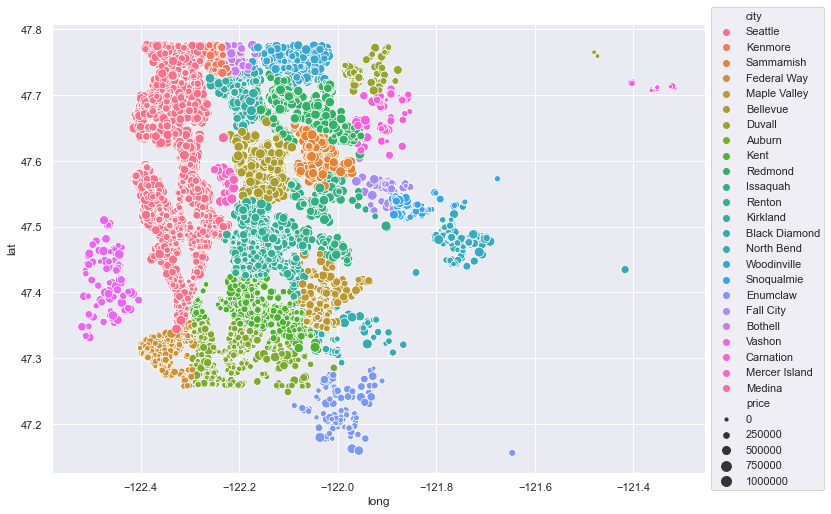

In [86]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

g = sns.scatterplot(house_data_2std.long, house_data_2std.lat, hue=house_data_2std.city, size=house_data_2std.price,
    sizes=(10, 100))
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True);

In [71]:
house_data['city']

0          Seattle
1          Seattle
2          Kenmore
3          Seattle
4        Sammamish
           ...    
21592      Seattle
21593      Seattle
21594      Seattle
21595     Issaquah
21596      Seattle
Name: city, Length: 21597, dtype: object

In [ ]:
# Our Real Estate focus is on houses $790,000 and under
# We can use the model to predict locations within the customer's price range
# If they are focused on an expensive area, we can help find adjacent cities to give them access nearby

In [ ]:
# As latitude increases (we move further north), prices increase generally

In [ ]:
# Kent, Kenmore, and Kirkland... that's unfortunate string of names